# CSE 252B: Computer Vision II, Winter 2024 – Assignment 1

Instructor: Ben Ochoa

Assignment due: Wed, Jan 17, 11:59 PM

**Name: Xiao Nan**

**PID: A69027384**

## Prior knowledge + certification of commencement of academic activity

Every course at UC San Diego, per the US Department of Education, is required to certify whether students have commenced academic activity for a class to be counted towards eligibility for Title IV federal financial aid. This certification must be completed during the first two weeks of instruction. For CSE 252B, this requirement will be fulfilled via an ungraded prior knowledge quiz, which will assist the instructional team by providing information about your background coming into the course. In Canvas (https://canvas.ucsd.edu), go to the CSE 252B course and navigate to Quizzes, then click on "First Day Survey: Prior Knowledge #FinAid"

## Instructions
* Review the academic integrity and collaboration policies on the course 
website.
* This assignment must be completed individually.
* All solutions must be written in this notebook.
* Math must be done in Markdown/LaTeX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* Your code should be well written with sufficient comments to understand, but there is no need to write extra markdown to describe your solution if it is not explictly asked for.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate efficient grading).
* You may use python packages for basic linear algebra, but you may not use functions that directly solve the problem. If you are uncertain about using a specific package, function, or method, then please ask the instructional staff whether it is allowable.
* **You must submit this notebook as an .ipynb file, a .py file, and a .pdf file on Gradescope.**
    - You may directly export the notebook as a .py file.  You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert the .ipynb file to a .py file using the following command
    `jupyter nbconvert --to script filename.ipynb`
    - There are two methods to convert the notebook to a .pdf file.
        - You may first export the notebook as a .html file, then print the web page as a .pdf file.
        - If you have XeTeX installed, then you may directly export the notebook as a .pdf file.  You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert a .ipynb file to a .pdf file using the following command
        `jupyter nbconvert --allow-chromium-download --to webpdf filename.ipynb`
    - **You must ensure the contents in each cell (e.g., code, output images, printed results, etc.) are clearly visible, and are not cut off or partially cropped in the .pdf file.**
    - Your code and results must remain inline in the .pdf file (do not move your code to an appendix).
    - **While submitting on gradescope, you must assign the relevant pages in the .pdf file submission for each problem.**
* It is highly recommended that you begin working on this assignment early.

# Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2.

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the $x$ and $y$ direction, respectively. Calculate the gradient images using the five-point
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Förstner corner point
operator.

You may use scipy.signal.convolve to perform convolution operation and scipy.ndimage.maximum_filter for NMS operation.

You may either directly use the color images for feature detection, or use the color to grayscale mapping $Y = 0.21263903 R + 0.71516871 G + 0.072192319 B$ to convert the images to grayscale first.

#### Report your final values for:
 * the size of the feature detection window (i.e., the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value
 * the size of the local nonmaximum suppression window
 * the resulting number of features detected (i.e., corners) in each image.

#### Display figures for:
 * minor eigenvalue images before thresholding
 * minor eigenvalue images after thresholding
 * original images with detected features

A typical implementation takes around 30 seconds to run. If yours takes more than 120 seconds, you may lose points.

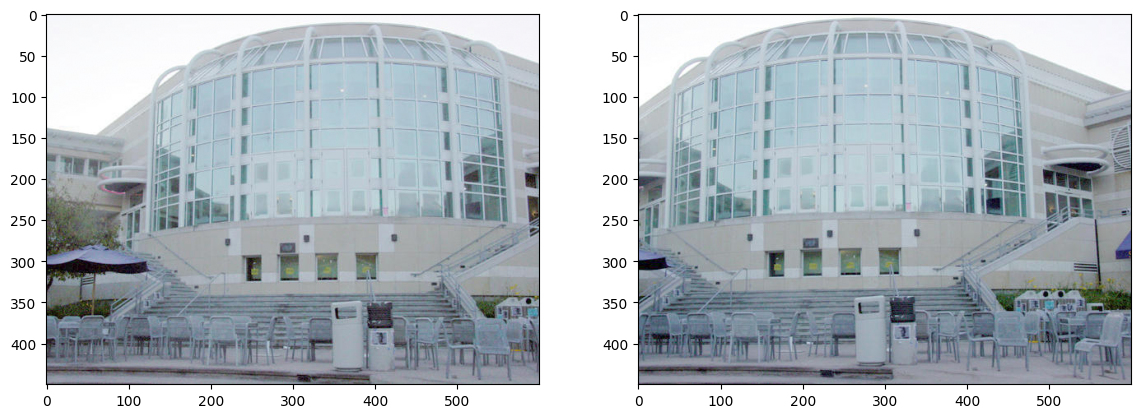

(450, 600, 3)


In [12]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time


# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()
print(I1.shape)
# print(I2.shape)

In [13]:
from scipy import signal
from scipy import ndimage

def color_to_gray(I):
    # converting to grayscale
    # input:
    # I: RGB image
    # output:
    # I_gray: grayscale image

    conversion = [0.21263903, 0.71516871, 0.072192319]
    I_gray = np.dot(I[...,:3], conversion)
    return I_gray

  
def image_gradient(I):
    # inputs:
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y

    m, n = I.shape[:2]
    k = np.array([[1./12, -8./12, 0, 8./12, -1./12]])
    k = -k # flip kernel for convolution
    Ix = np.zeros((m,n,3))
    Iy = np.zeros((m,n,3))

    """your code here"""
    for channel in range(I.shape[2]):
        # guarantee valid gradients
        Ixc = signal.convolve(I[:,:,channel], k, mode="valid") 
        Iyc = signal.convolve(I[:,:,channel], k.T, mode="valid")

        # zero-pad to maintain size
        Ix[:,:,channel] = np.pad(Ixc, ((0, 0), (2, 2)), 'constant', constant_values=0) 
        Iy[:,:,channel] = np.pad(Iyc, ((2, 2), (0, 0)), 'constant', constant_values=0)
    return Ix, Iy

def minor_eigenvalue_image(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]

    # pad to align
    pad_size = w//2

    # compute quadratics
    Ix2 = Ix*Ix
    Ix2 = np.sum(Ix2, axis=2)
    Ixy = Ix*Iy
    Ixy = np.sum(Ixy, axis=2)
    Iy2 = Iy*Iy
    Iy2 = np.sum(Iy2, axis=2)
    
    #Calculate your minor eigenvalue image J0.
    J0 = np.zeros((m,n))
    for i in range(pad_size, m-pad_size):
        for j in range(pad_size, n-pad_size):
            M = np.array([[np.sum(Ix2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]),
                                   np.sum(Ixy[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])],
                                   [np.sum(Ixy[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]),
                                   np.sum(Iy2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])]])
            Tr = np.trace(M)
            Det = 4*np.linalg.det(M)
            Delta = max(0, Tr*Tr - Det)
            J0[i,j] = (0.5) * (Tr - np.sqrt(Delta))   

    return J0

def nms(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs:
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    #

    J2 = J.copy()
    J = ndimage.maximum_filter(J, size=w_nms)
    J2[J2 < J] = 0
    return J2

def forstner_corner_detector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    J0 = minor_eigenvalue_image(Ix, Iy, w)
    J1 = J0.copy()
    # print(J1)
    J1[J1 < t] = 0


    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = nms(J1, w_nms)

    #Detect corners. (global thresholding ignored)
    C = np.sum(J2!=0)
    coords = J2.nonzero()
    print("number of cornors detected: {}".format(C))
    # print(np.max(coords[0]), np.max(coords[1]))

    # compute quadratics
    Ix2 = Ix*Ix
    Ix2 = np.sum(Ix2, axis=2)
    Ixy = Ix*Iy
    Ixy = np.sum(Ixy, axis=2)
    Iy2 = Iy*Iy
    Iy2 = np.sum(Iy2, axis=2)
    x = np.linspace(0, m-1, m)
    y = np.linspace(0, n-1, n)
    xv, yv = np.meshgrid(x, y, indexing='ij') # matrix indexing
    # print(xv.shape, Ix2.shape, yv.shape, Ixy.shape)
    # print(xv, Ix2, yv, Ixy)
    b1 = xv*Ix2 + yv*Ixy
    b2 = xv*Ixy + yv*Iy2
    pad_size = w//2 # grad window size = cornor search window size

    # iterate to get cornors in the patches
    # Done: Find non-zero corner-like window centers and compute cornors' locations
    pts = np.zeros((2, C))
    cnt = 0
    for i, j in zip(coords[0], coords[1]):
        x_left_lim, x_right_lim = max(0, i-pad_size), min(n, i+pad_size+1)
        y_up_lim, y_down_lim = max(0, j-pad_size), min(n, j+pad_size+1)
        A = np.array([[np.sum(Ix2[x_left_lim:x_right_lim, y_up_lim:y_down_lim]),
                    np.sum(Ixy[x_left_lim:x_right_lim, y_up_lim:y_down_lim])],
                    [np.sum(Ixy[x_left_lim:x_right_lim, y_up_lim:y_down_lim]),
                    np.sum(Iy2[x_left_lim:x_right_lim, y_up_lim:y_down_lim])]])
        b = np.array([[np.sum(b1[x_left_lim:x_right_lim, y_up_lim:y_down_lim])],
                    [np.sum(b2[x_left_lim:x_right_lim, y_up_lim:y_down_lim])]])
        x = np.dot(np.linalg.inv(A),b)
        pts[:, cnt] = x[::-1,0]
        cnt += 1
    return C, pts, J0, J1, J2


# feature detection
def run_feature_detection(I, w, t, w_nms):
    Ix, Iy = image_gradient(I)
    C, pts, J0, J1, J2 = forstner_corner_detector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

In [14]:
# ImageGradient() unit test
def check_values(I, target):
    eps = 1e-8  # Floating point error threshold
    I = I[2:-2, 2:-2]  # Ignore border values
    valid = np.all((I < target + eps) & (I > target - eps))
    print(f'Image is all equal to {target} +/- {eps}: {valid}')

def gray_to_RGB(I):
    h, w = I.shape
    I = np.expand_dims(I, axis=-1)
    return np.broadcast_to(I, (h, w, 3))

rampx = np.array(Image.open('rampx.png'), dtype='float')
rampy = np.array(Image.open('rampy.png'), dtype='float')

# If you are using grayscale images in ImageGradient(), comment out these lines
rampx = gray_to_RGB(rampx)
rampy = gray_to_RGB(rampy)

# rampx_Ix should be all ones, rampx_Iy should be all zeros (to floating point error)
rampx_Ix, rampx_Iy = image_gradient(rampx)
# print(rampx_Ix)
check_values(rampx_Ix, 1)
check_values(rampx_Iy, 0)

# rampy_Ix should be all zeros, rampx_Iy should be all ones (to floating point error)
rampy_Ix, rampy_Iy = image_gradient(rampy)
check_values(rampy_Ix, 0)
check_values(rampy_Iy, 1)

Image is all equal to 1 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 1 +/- 1e-08: True


number of cornors detected: 612
number of cornors detected: 632
took 17.062477 secs
C1=612, C2=632


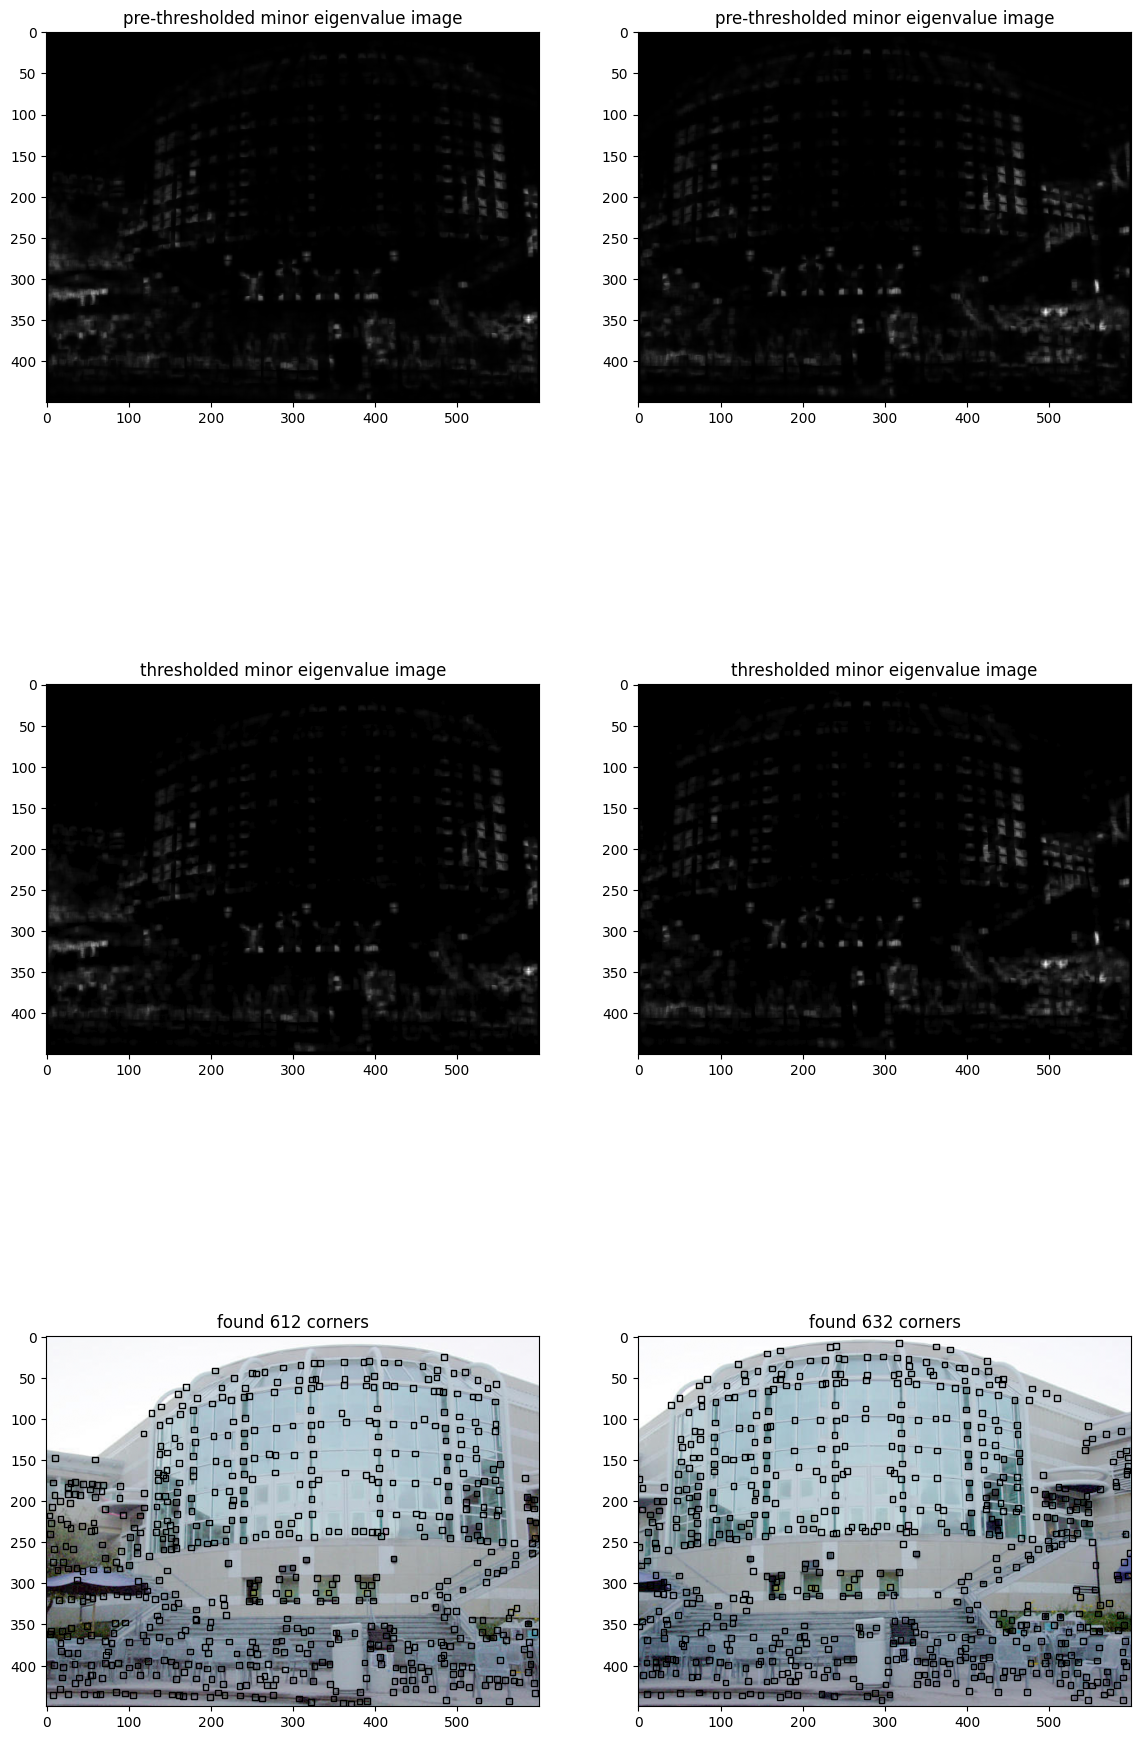

In [15]:
# input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.06
w_nms = 9

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = run_feature_detection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = run_feature_detection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)
print("C1={}, C2={}".format(C1, C2))

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.06
* w_nms = 9
* C1 = 612
* C2 = 632

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that 160-240 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1. The proximity is calculated using the subpixel coordinates of the detected feature coordinates in image 1 and image 2.  Given $(x_1, y_1)$ in image 1 and $(x_2, y_2)$ in image 2, you can think of a square with side length $p$, centered at $(x_2, y_2)$. Then, $(x_1, y_1)$ is within the proximity window if it lies inside that square.

Use the following formula to calculate the correlation coefficient (normalized cross correlation) between two image windows $I_1$ and $I_2$:
$$\frac{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right] \left[ I_2(x, y) - \overline{I_2} \right] }{\sqrt{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right]^2 \cdot \sum_{x, y}\left[ I_2(x, y) - \overline{I_2} \right]^2}}$$

where $I(x, y)$ is the pixel value of $I$ at $(x, y)$ and $\overline{I}$ is the mean value of $I$.

**Note: You must center each window at the sub-pixel corner coordinates while computing normalized cross correlation, i.e., you must use bilinear interpolation to compute the pixel values at non-integer coordinates; otherwise, you will lose points.**

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e., matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature.

(You must use original (color) images to the draw boxes and correspondence lines)

A typical implementation takes around 10 seconds to run. If yours takes more than 120 seconds, you may lose points.


In [16]:
from scipy.interpolate import RegularGridInterpolator

def bilinear_interpolation1(pts,I_gray,w):
    # inputs:
    # pts: center points
    # I_gray: grayscale converted input image
    # w: window size
    #
    # output:
    # Interpolated pixel values for the corner windows

    half_win = w//2
    I_gray = np.pad(I_gray,pad_width=half_win)
    x = np.linspace(0,I_gray.shape[1]-1,I_gray.shape[1])
    y = np.linspace(0,I_gray.shape[0]-1,I_gray.shape[0])
    interp = RegularGridInterpolator((y, x),I_gray, bounds_error=False, fill_value=None)

    windows = []

    for c in range(pts.shape[1]):
    #   print(pts[0][c]-half_win,pts[0][c]+half_win+1,2*half_win-1)
      xx = np.linspace(pts[0][c]-half_win,pts[0][c]+half_win+1,2*half_win-1)
      yy = np.linspace(pts[1][c]-half_win,pts[1][c]+half_win+1,2*half_win-1)
      X, Y = np.meshgrid(xx, yy, indexing='ij')
      w1 = interp((Y,X)) # interpolate on a floating-point window
      windows.append(w1)

    return windows

def get_corr_coeff(wind1_curr, wind2_curr):
    # get correlation coefficient between windows 1 and 2 based on greyscale computations
    I1mean, I2mean = np.mean(wind1_curr), np.mean(wind2_curr)
    shifted_wind1, shifted_wind2 = wind1_curr-I1mean, wind2_curr-I2mean
    corr = np.sum(shifted_wind1 * shifted_wind2) / np.sqrt(np.sum(shifted_wind1**2) * np.sum(shifted_wind2**2))
    assert(-1.0 <= corr <= 1.0)
    return corr

def compute_ncc(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # Do ensure that windows are centered at the sub-pixel co-ordinates
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in
    #    image 1 and all windows in image 2
    #
    
    # get cross correlation matrix
    l1, l2 = pts1.shape[1], pts2.shape[1]
    I1_gray, I2_gray = color_to_gray(I1), color_to_gray(I2)
    wind1, wind2 = bilinear_interpolation1(pts1, I1_gray, w), bilinear_interpolation1(pts2, I2_gray, w)
    scores = np.zeros((l1, l2))
    for i in range(l1):
        for j in range(l2):
            pt1, pt2 = pts1[:, i], pts2[:, j]
            if (np.linalg.norm(pt1 - pt2) < p):
                wind1_curr, wind2_curr = wind1[i], wind2[j]
                corr = get_corr_coeff(wind1_curr, wind2_curr)
                scores[i, j] = corr
            else:
                scores[i, j] = -1.0
    return scores


def perform_match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    #
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    ind_I1 = []
    ind_I2 = []
    mask = np.ones(scores.shape)
    masked_scores = scores * mask
    while (np.max(masked_scores) > t):
        # get best and the next best correlation coefficients' values
        max_index = np.unravel_index(np.argmax(masked_scores, axis=None), masked_scores.shape)
        max_val = scores[max_index]
        scores[max_index] = -1
        # print(np.max(scores[max_index[0], :]), np.max(scores[:, max_index[1]]))
        next_best_val = np.max([np.max(scores[max_index[0], :]), np.max(scores[:, max_index[1]])])
        scores[max_index] = max_val

        # if best value is much better than the second best: keep the best val
        if ((1 - max_val) < ((1 - next_best_val) * d)): 
            ind_I1.append(max_index[0])
            ind_I2.append(max_index[1])
        
        # remove matched windows from considerations 
        mask[max_index[0], :] = 0
        mask[:, max_index[1]] = 0
        masked_scores = scores * mask
    print("The number of matches found: {}".format(len(ind_I1)))
    return np.array([ind_I1, ind_I2])


def run_feature_matching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches

    scores = compute_ncc(I1, I2, pts1, pts2, w, p)
    inds = perform_match(scores, t, d)
    return inds

The number of matches found: 218
took 3.592571 secs


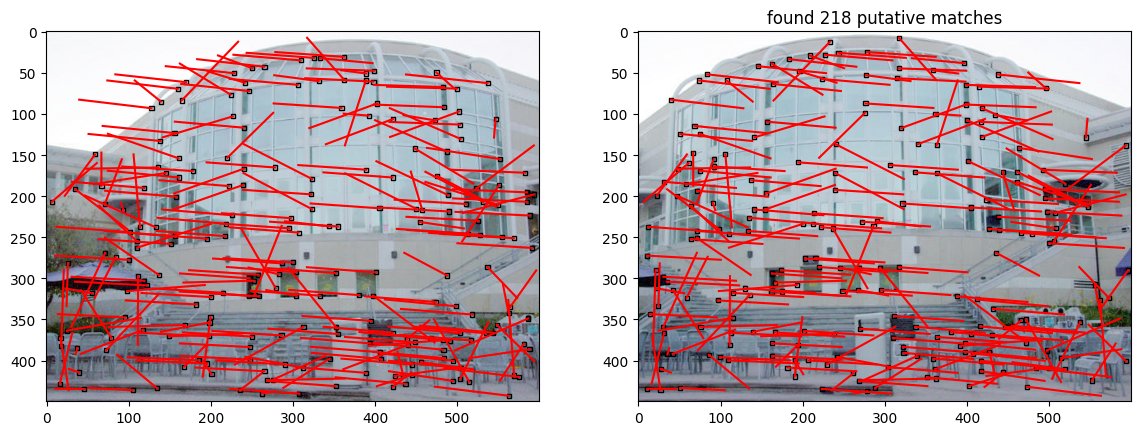

unique points in image 1: 218
unique points in image 2: 218


In [17]:
# parameters to tune
w = 5
t = 0.01
d = 0.85
p = 100

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = run_feature_matching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 5
* t = 0.01
* d = 0.85
* p = 100
* num_matches = 218